# Spectroscopic Lensing

## Imports

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import medfilt

from astropy.table import Table, vstack, join
from astropy.io import fits

import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.spectra import Spectra

from desisim.templates import BGS, ELG

import redrock.templates
import redrock.results
from redrock.external import desi
 
from desi_myfunctions import *

import time

%matplotlib inline

In [2]:
import numpy as np

from redrock import zwarning


class PlotSpec(object):
    def __init__(self, targets, templates, zscan, zfit, truth=None, archetypes=False):
        """TODO: document
        """

        #- Isolate imports of optional dependencies
        import matplotlib.pyplot as plt

        #- Only keep targets that are in the zfit table
        keeptargets = list()
        keepids = set(zfit['targetid'])
        for t in targets:
            if t.id in keepids:
                keeptargets.append(t)

        self.targets = keeptargets
        self.templates = templates
        self.archetypes = archetypes
        self.zscan = zscan
        self.zfit = zfit
        self.itarget = 0
        self.znum = 0
        self.smooth = 1
        self.truth = truth
        self.targetid_to_itarget = {}
        for i, t in enumerate(self.targets):
            self.targetid_to_itarget[t.id] = i

        ################################################################            
        # I adjusted the plot size by adding figsize, 
        # to revert back to the original size uncomment code below
    
        self._fig = plt.figure(figsize=(16,8))
        
        ################################################################
        #self._fig = plt.figure()
        self._ax1 = self._fig.add_subplot(211)
        self._ax2 = self._fig.add_subplot(212)

        self._cid = self._fig.canvas.mpl_connect('key_press_event',
            self._onkeypress)

        #- Instructions
        '''print("---------------------------------------------------------------"
            "----------")
        print("Select window then use keyboard shortcuts to navigate:")
        print("    up/down arrow: previous/next target")
        print("    left/right arrow: previous/next redshift fit for this"
            " target")
        print("    (d)etails")
        print("---------------------------------------------------------------"
            "----------")'''

        #- Disable some default matplotlib key bindings so that we can use keys
        #- TODO: cache and reset when done
        plt.rcParams['keymap.forward'] = ''
        plt.rcParams['keymap.back'] = ''

        plt.ion()
        self.plot()
        #plt.show( block=True )

    def _onkeypress(self, event):
        ### print('key', event.key)
        if event.key == 'right':
            self.znum = (self.znum + 1) % self.nznum
            self.plot(keepzoom=True)
        elif event.key == 'left':
            self.znum = (self.znum - 1) % self.nznum
            self.plot(keepzoom=True)
        elif event.key == 'down':
            if self.itarget == min(len(self.targets),len(self.zscan))-1:
                print('At last target')
            else:
                self.znum = 0
                self.itarget += 1
                self.plot()
        elif event.key == 'up':
            if self.itarget == 0:
                print('Already at first target')
            else:
                self.znum = 0
                self.itarget -= 1
                self.plot()
        elif event.key == 'd':
            target = self.targets[self.itarget]
            zfit = self.zfit[self.zfit['targetid'] == target.id]
            print('target {}'.format(target.id))
            print(zfit['znum', 'spectype', 'z', 'zerr', 'zwarn', 'chi2'])

    def plot(self, keepzoom=False):

        #- Isolate imports of optional dependencies
        from scipy.signal import medfilt

        target = self.targets[self.itarget]
        zfit = self.zfit[self.zfit['targetid'] == target.id]
        self.nznum = len(zfit)
        zz = zfit[zfit['znum'] == self.znum][0]
        coeff = zz['coeff']

        fulltype = zz['spectype']
        if zz['subtype'] != '':
            fulltype = fulltype+':::'+zz['subtype']
        if self.archetypes:
            dwave = { s.wavehash:s.wave for s in target.spectra }
            tp = self.archetypes.archetypes[zz['spectype']]
        else:
            tp = self.templates[fulltype]
            if tp.template_type != zz['spectype']:
                raise ValueError('spectype {} not in'
                    ' templates'.format(zz['spectype']))

        #----- zscan plot
        '''if keepzoom:
            force_xlim = self._ax1.get_xlim()
            force_ylim = self._ax1.get_ylim()'''

        #self._ax1.clear()
        '''for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
            if spectype in self.zscan[target.id]:
                zx = self.zscan[target.id][spectype]
                self._ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                    label='_none_')
                self._ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                    label=spectype)'''
        
        #####################################################################
        
        # MY ADJUSTMENTS TO PLOT ONLY GALAXY CHI2
        # To return to original code, delete this and uncomment code above
        
        spectype = 'GALAXY'
        fmt = 'b-'
        
        if spectype in self.zscan[target.id]:
            zx = self.zscan[target.id][spectype]
            self._ax1.plot(zx['redshifts'], np.log10(zx['zchi2']), fmt, alpha=0.2,
                label='_none_')
            self._ax1.plot(zx['redshifts'], np.log10(zx['zchi2']+zx['penalty']), fmt,
                label=spectype)
        
        ####################################################################

        self._ax1.plot(zfit['z'], np.log10(zfit['chi2']), 'r.', label='_none_')
        for row in zfit:
            self._ax1.text(row['z'], np.log10(row['chi2']), str(row['znum']),
                verticalalignment='top')

        if self.truth is not None:
            i = np.where(self.truth['targetid'] == target.id)[0]
            if len(i) > 0:
                ztrue = self.truth['ztrue'][i[0]]
                self._ax1.axvline(ztrue, color='g', alpha=0.5)
            else:
                print('WARNING: target id {} not in truth'
                    ' table'.format(target.id))

        self._ax1.axvline(zz['z'], color='k', alpha=0.1)
        self._ax1.axhline(np.log10(zz['chi2']), color='k', alpha=0.1)
        self._ax1.legend()
        self._ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id,
            zz['z'], zz['spectype']))
        self._ax1.set_ylabel(r'$\chi^2$')
        self._ax1.set_xlabel('redshift')
        '''if keepzoom:
            self._ax1.set_xlim(*force_xlim)
            self._ax1.set_ylim(*force_ylim)'''

        #----- spectrum plot
        if keepzoom:
            force_xlim = self._ax2.get_xlim()
            force_ylim = self._ax2.get_ylim()

        self._ax2.clear()
        ymin = ymax = 0.0
        specs_to_read = target.spectra
        for spec in specs_to_read:
            if self.archetypes:
                mx = tp.eval(zz['subtype'], dwave, coeff, spec.wave, zz['z']) * (1+zz['z'])
            else:
                mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
            model = spec.R.dot(mx)
            flux = spec.flux.copy()
            isbad = (spec.ivar == 0)
            ## model[isbad] = mx[isbad]
            flux[isbad] = np.NaN
            self._ax2.plot(spec.wave, medfilt(flux, self.smooth), alpha=0.5)
            self._ax2.plot(spec.wave, medfilt(mx, self.smooth), 'k:', alpha=0.8)
            model[isbad] = np.NaN
            self._ax2.plot(spec.wave, medfilt(model, self.smooth), 'k-',
                alpha=0.8)

            if flux[~isbad].size!=0:
                ymin = min(ymin, np.percentile(flux[~isbad], 1))
                ymax = max(ymax, np.percentile(flux[~isbad], 99),
                    np.max(model)*1.05)

        if (ymin==0.) & (ymax==0.):
             ymax = 1.

        #- Label object type and redshift
        label = 'znum {} {} z={:.3f}'.format(self.znum, fulltype, zz['z'])
        print('target {} id {} {}'.format(self.itarget, target.id, label))
        ytext = ymin+0.9*(ymax-ymin)
        self._ax2.text(3800, ytext, label)

        #- ZWARN labels
        if zz['zwarn'] != 0:
            label = list()
            for name, mask in zwarning.ZWarningMask.flags():
                if (zz['zwarn'] & mask) != 0:
                    label.append(name)
            label = '\n'.join(label)
            color = 'r'
        else:
            label = 'ZWARN=0'
            color = 'g'

        self._ax2.text(10000, ytext, label, horizontalalignment='right',
            color=color)

        self._ax2.axhline(0, color='k', alpha=0.2)
        if keepzoom:
            self._ax2.set_xlim(*force_xlim)
            self._ax2.set_ylim(*force_ylim)
        else:
            self._ax2.set_ylim(ymin, ymax)
            self._ax2.set_xlim(3500,10100)

        self._ax2.set_ylabel('flux')
        self._ax2.set_xlabel('wavelength [A]')
        # self._fig.tight_layout()
        self._fig.canvas.draw()

In [3]:
start = time.time()

## Functions

In [4]:
# Check if the outfile exists and if not run the input command

def chkfile(cmd, outfile, overwrite=False):
    
    if os.path.exists(outfile) == True and overwrite == False:
        
        return None
    
    elif os.path.exists(outfile) == True and overwrite == True:
        
        !$cmd
    
    else:
        
        !$cmd
        
# Find second magnitude based on flux ratio and first magnitude        
        
def maggen(mag, fratio=1):
    
    newmag = -2.5*np.log10(fratio)+mag
    
    return newmag

def setlims(x, y):
    
    if max(x) > max(y):
        maximum = max(x) + 0.2
    
    if max(x) < max(y):
        maximum = max(y) + 0.2
    
    if min(x) > min(y):
        minimum = min(y) - 0.2
    
    if min(x) < min(y):
        minimum = min(x) - 0.2
        
    lims = (minimum, maximum)
    
    return lims

## Simulate and Combine Spectra

In [5]:
fileloc = os.path.join(os.getenv('HOME'), 'specLensing', 'fitsfiles', 'spec_lens_100zs_0.1')
fratio = 0.1
BGSmag = 20
ELGmag = maggen(BGSmag, fratio)
ELGseed = 50
BGSseed = 79
nrshifts = 100
BGSrshifts = None
ELGrshifts = None

if nrshifts is not None:
    combwave, combflux, BGSmeta, ELGmeta, BGSflux, ELGflux = combspec(ELGmag, BGSmag, ELGseed, BGSseed, nrShifts=nrshifts, returnmeta=True, sepflux=True)

if BGSrshifts is not None and ELGrshifts is not None:
    combwave, combflux, BGSmeta, ELGmeta, BGSflux, ELGflux = combspec(ELGmag, BGSmag, ELGseed, BGSseed, BGSrShifts=BGSrshifts, ELGrShifts=ELGrshifts, returnmeta=True, sepflux=True)

fitsfile = 'combined_spectra_data.fits'

writefits(fileloc, fitsfile, combwave, 'Angstrom', hdrname='Wavelength', overwrite=True)
writefits(fileloc, fitsfile, combflux, '10^-17 erg/(s*cm^2*Angstrom)', hdrname='Flux', overwrite=True)

infile = os.path.join(fileloc, fitsfile)
outfile = os.path.join(fileloc, 'quick_outfile.fits')

cmd = 'quickspectra -i {} -o {} --seeing 1.1 --airmass 1.1 --exptime 200'.format(infile, outfile)
chkfile(cmd, outfile)

INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
INFO:quickspectra.py:344:main: Reading an input FITS file
INFO:quickspectra.py:379:main: input flux shape = (100, 32001)
INFO:quickspectra.py:61:sim_spectra: Starting simulation of 100 spectra
INFO:iers.py:78:freeze_iers: Freezing IERS table used by astropy time, coordinates.
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 200.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.1
DEBUG:simexp.py:448

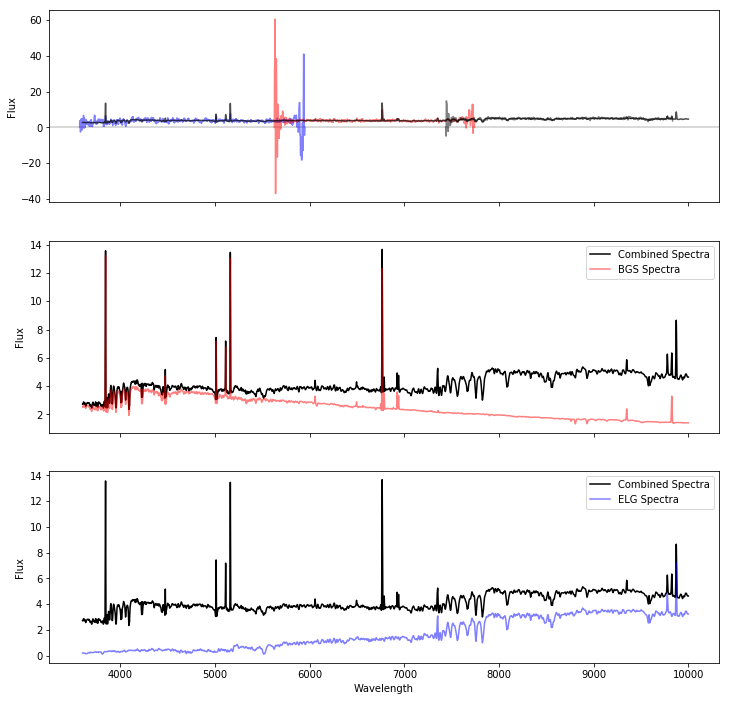

In [6]:
i = 12

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12, 12), sharex=True)

plotobsspectra(outfile, specnum=i, ax=ax1, trueflux=combflux, truewave=combwave)
ax1.set_ylabel('Flux')

ax2.plot(combwave, combflux[i], 'k-', label='Combined Spectra')
ax2.plot(combwave, BGSflux[i], 'r-', label='BGS Spectra', alpha=0.5)
ax2.set_ylabel('Flux')
ax2.legend()

ax3.plot(combwave, combflux[i], 'k-', label='Combined Spectra')
ax3.plot(combwave, ELGflux[i], 'b-', label='ELG Spectra', alpha=0.5)
ax3.set_ylabel('Flux')
ax3.set_xlabel('Wavelength')
ax3.legend()

## Run through Redrock to find BGS

In [7]:
zoutfile = os.path.join(fileloc, 'rr_z_out.fits')
h5outfile = os.path.join(fileloc, 'rr_h5_out.h5')

cmd = 'rrdesi {} -z {} -o {}'.format(outfile, zoutfile, h5outfile)
chkfile(cmd, zoutfile)

Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 100 targets: 1.4 seconds
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default 

Text(0,0.5,'N')

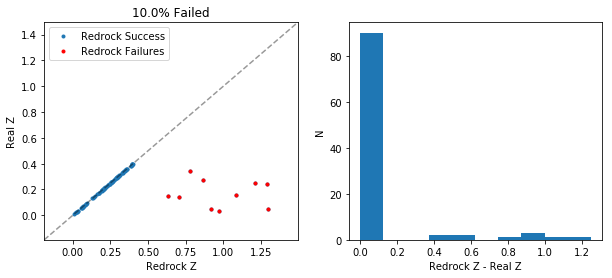

In [8]:
BGSz = BGSmeta['REDSHIFT']
ELGz = ELGmeta['REDSHIFT']

zbest = Table.read(zoutfile, 'ZBEST')
zbest['dz'] = zbest['Z'] - BGSz

rrfail = np.where(np.abs(zbest['dz']) > 0.003)
failrate = len(zbest[rrfail]) / len(zbest)

dlim = setlims(zbest['Z'], BGSz)

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(zbest['Z'], BGSz, '.', label='Redrock Success')
ax[0].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.4)
ax[0].plot(zbest['Z'][rrfail], BGSz[rrfail], 'r.', label='Redrock Failures')
ax[0].set_ylim(dlim)
ax[0].set_xlim(dlim)
ax[0].set_ylabel('Real Z')
ax[0].set_xlabel('Redrock Z')
ax[0].title.set_text('{}% Failed'.format(failrate*100))
ax[0].legend()

ax[1].hist(zbest['dz'])
ax[1].set_xlabel('Redrock Z - Real Z')
ax[1].set_ylabel('N')

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


target 0 id 4 znum 0 GALAXY z=0.776


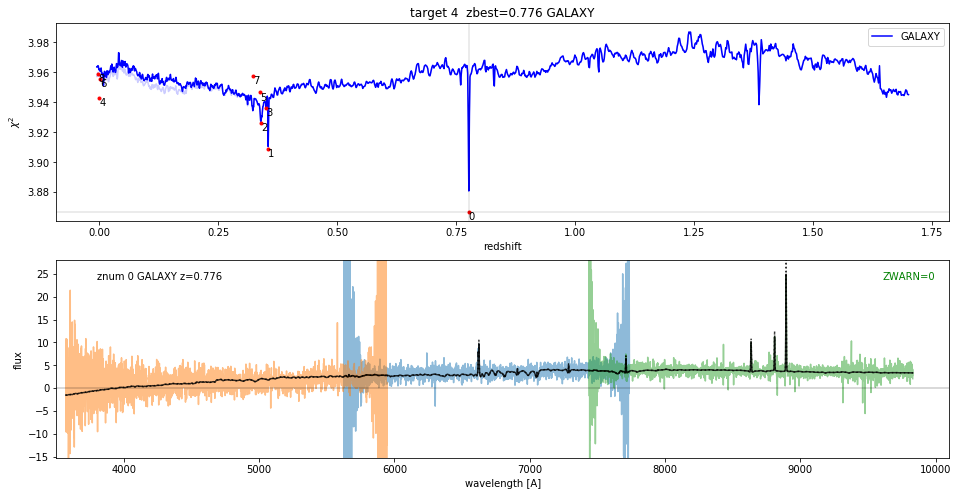

In [9]:
i = 4
templates = {}

tempfile = redrock.templates.find_templates()[0]
rrtemp = redrock.templates.Template(tempfile, wave=combwave)

z = Table.read(h5outfile, 'zbest')

zscan, zfit = redrock.results.read_zscan(h5outfile)
targets = desi.DistTargetsDESI(outfile, targetids=[z['targetid'][i]])._my_data
templates[rrtemp.full_type] = rrtemp

PlotSpec(targets, templates, {0: zscan}[0], zfit)

## Subtract and Run through Redrock again

In [10]:
specfiles = rrtemp_to_spectra(outfile, zbest=zbest)

zfiles = []
h5files = []

for file in specfiles:
    
    zresout = os.path.join(fileloc, 'res_rrfits_out_{}.fits'.format(file[len(fileloc)+42:]))
    h5resout = os.path.join(fileloc, 'res_rrh5_out_{}.h5'.format(file[len(fileloc)+42:]))
    
    cmd = 'rrdesi {} -o {} -z {}'.format(file, h5resout, zresout)
    chkfile(cmd, h5resout)
    
    zfiles.append(zresout)
    h5files.append(h5resout)

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 1 targets: 0.1 seconds
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default re

Text(0.5,0,'Redrock Z - Real Z')

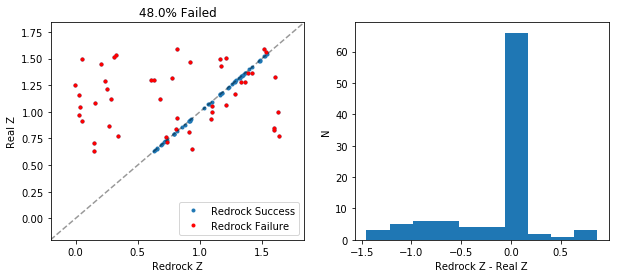

In [11]:
reszbest = []
for file in zfiles:
    
    zdata = Table.read(file, 'ZBEST')
    reszbest.append(zdata)
    
reszbest = vstack(reszbest)

reszbest['dz'] = reszbest['Z'] - ELGz
rrfail = np.where(np.abs(reszbest['dz']) > 0.003)
failrate = len(reszbest[rrfail]) / len(zbest)

dlim = setlims(reszbest['Z'], ELGz)

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(reszbest['Z'], ELGz, '.', label='Redrock Success')
ax[0].plot(reszbest['Z'][rrfail], ELGz[rrfail], 'r.', label='Redrock Failure')
ax[0].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.4)
ax[0].set_ylim(dlim)
ax[0].set_xlim(dlim)
ax[0].set_ylabel('Real Z')
ax[0].set_xlabel('Redrock Z')
ax[0].title.set_text('{}% Failed'.format(failrate*100))
ax[0].legend()

ax[1].hist(reszbest['dz'])
ax[1].set_ylabel('N')
ax[1].set_xlabel('Redrock Z - Real Z')

In [12]:
pererr = []

for i, val in enumerate(ELGz):
    
    err = np.abs((reszbest['Z'][i] - val)) / val
    pererr.append(err)
    
reszbest['error'] = pererr
reszbest['realz'] = ELGz

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
target 0 id 4 znum 0 GALAXY z=0.340


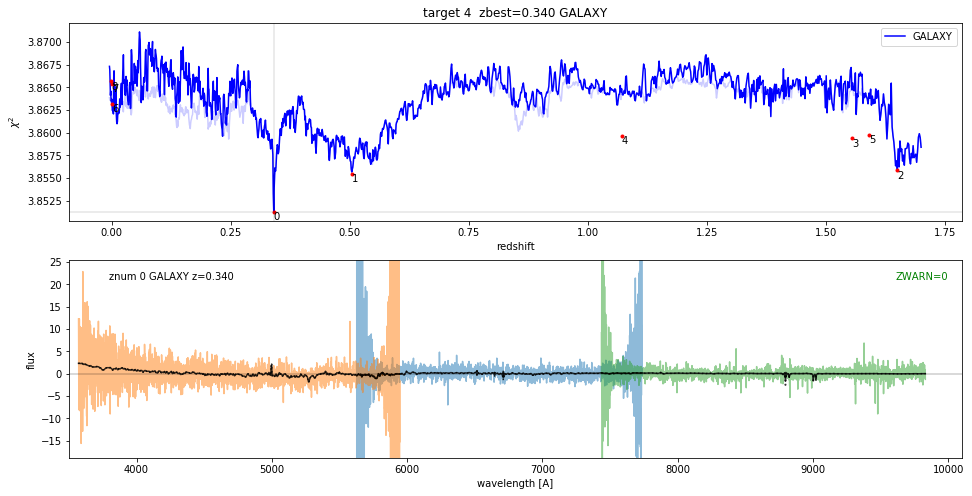

In [21]:
h5data = []
templates = {}
i = 4

for file in h5files:
    z = Table.read(file, 'zbest')
    h5data.append(z)

h5data = vstack(h5data)

zscan, zfit = redrock.results.read_zscan(h5files[i])

ELGtempfile = redrock.templates.find_templates()[0]
ELGrrtemp = redrock.templates.Template(ELGtempfile, wave=combwave, spectype='GALAXY')
targets = desi.DistTargetsDESI(specfiles[i], targetids=h5data['targetid'])._my_data
templates[ELGrrtemp.full_type] = ELGrrtemp
    
PlotSpec(targets, templates, zscan, zfit)

# Plot of Templates over combined data

In [14]:
temps = {'BGSflux': [], 'BGSwave': [], 'ELGflux': [], 'ELGwave': []}
    
for i in range(len(zbest)):
        
    nBGScoeff = rrtemp.flux.shape[0]
    BGScoeff = zbest['COEFF'][i][:nBGScoeff]
    temps['BGSflux'].append(rrtemp.flux.T.dot(BGScoeff))
    temps['BGSwave'].append(rrtemp.wave * (1+zbest[i]['Z']))
    
    nELGcoeff = ELGrrtemp.flux.shape[0]
    ELGcoeff = reszbest['COEFF'][i][:nELGcoeff]
    temps['ELGflux'].append(ELGrrtemp.flux.T.dot(ELGcoeff))
    temps['ELGwave'].append(ELGrrtemp.wave * (1+reszbest[i]['Z']))

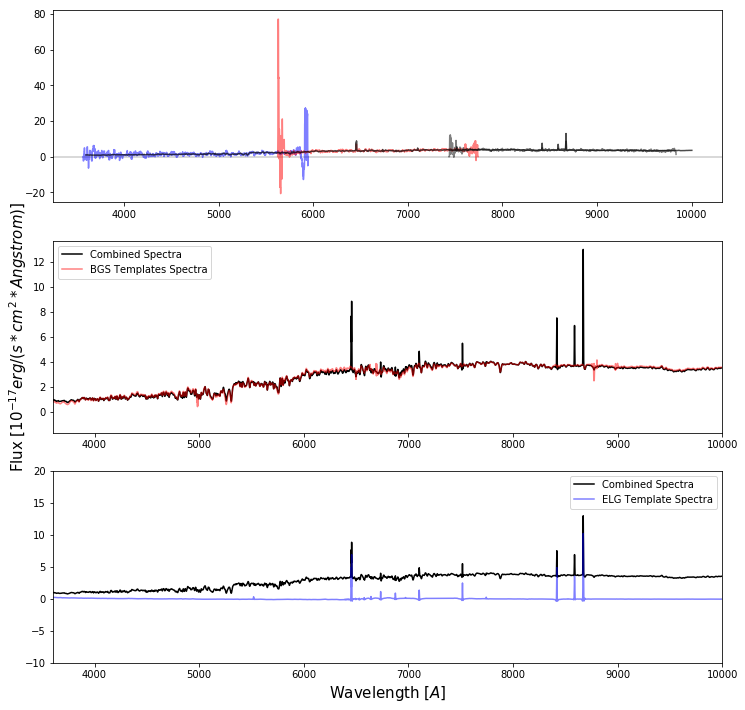

In [15]:
i = 7

fig, (ax3, ax1, ax2) = plt.subplots(3,1,figsize=(12, 12), sharex=False)

plotobsspectra(outfile, specnum=i, ax=ax3, trueflux=combflux, truewave=combwave)
#ax3.set_ylabel('Flux', fontsize=15)

ax1.plot(combwave, combflux[i], 'k-', label='Combined Spectra')
ax1.plot(temps['BGSwave'][i], temps['BGSflux'][i], 'r-', label='BGS Templates Spectra', alpha=0.5)
ax1.set_ylabel('Flux [$10^{-17} erg/(s*cm^2*Angstrom)$]', fontsize=15)
ax1.set_xlim(3600, 10000)
ax1.legend()

ax2.plot(combwave, combflux[i], 'k-', label='Combined Spectra')
ax2.plot(temps['ELGwave'][i], temps['ELGflux'][i], 'b-', label='ELG Template Spectra', alpha=0.5)
#ax2.set_ylabel('Flux', fontsize=15)
ax2.set_xlabel('Wavelength [$A$]', fontsize=15)
ax2.set_xlim(3600, 10000)
ax2.set_ylim(-10,20)
ax2.legend()

In [16]:
from scipy.stats import mannwhitneyu as mwu

ELGstat, ELGp = mwu(ELGz, reszbest['Z'])
BGSstat, BGSp = mwu(BGSz, zbest['Z'])

print('ELG p-value: {}\nBGS p-value: {}'.format(ELGp, BGSp))

ELG p-value: 0.016111619350291644
BGS p-value: 0.05936767633718148


Since the BGS p-value is greater than 0.05, it means that the actual BGS data and the Redrock BGS redshifts are statistically similar. Although, the ELG p-value is less than 0.05 so the real ELG redshifts and the Redrock ELG redshifts are not statistically alike

In [61]:
end = time.time()

hours = (end - start) / 3600
mins = (hours - int(hours)) * 60
sec = (mins - int(mins)) * 60

print('Runtime (hrs:min:sec) is {} : {} : {}'.format(int(hours), int(mins), sec))

Runtime (hrs:min:sec) is 1 : 54 : 3.50420784950245
